In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
from keras import metrics



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
limit_mem()

In [3]:
path = '../datasets/imagenet/sample/'
dpath = '../datasets/imagenet/sample/'

In [4]:
fnames = glob.glob(path + '**/*.JPEG', recursive=True)
n = len(fnames)
n

19439

In [5]:
fn = fnames[50]; 
fn

'../datasets/imagenet/sample/train/n02817516/n02817516_61417.JPEG'

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [7]:
deproc = lambda x, shp: np.clip(x.reshape(shp)[:, :, :, ::-1] + rn_mean, 0, 255)

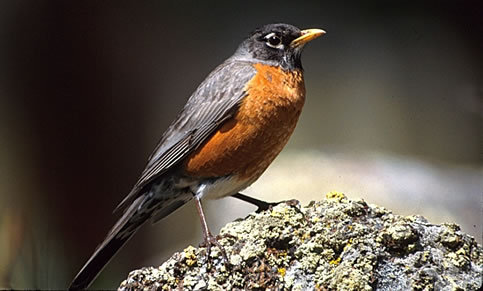

In [8]:
fn = '../datasets/imagenet/sample/train/n01558993/n01558993_9684.JPEG'
img = Image.open(fn)
img

In [9]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [10]:
from vgg16_avg import VGG16_Avg
import vgg16_avg; importlib.reload(vgg16_avg)


<module 'vgg16_avg' from '/fastai/deeplearning2/vgg16_avg.py'>

In [11]:
model = VGG16_Avg(include_top=False)

In [12]:
layer = model.get_layer('block5_conv1').output
print(layer)

Tensor("block5_conv1/Relu:0", shape=(?, ?, ?, 512), dtype=float32)


In [13]:
layer_model = Model(model.input, layer)

targ = K.variable(layer_model.predict(img_arr))
print(targ)

<tf.Variable 'Variable:0' shape=(1, 18, 30, 512) dtype=float32_ref>


In [14]:
layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [15]:
??metrics.mse

In [16]:
loss = metrics.mse(K.reshape(layer, (1, -1)), K.reshape(targ, (1, -1)))
grads = K.gradients(loss, model.input)
fnc = K.function([model.input], [loss] + grads)

In [17]:
model.input is layer_model.input

True

In [18]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grad_values.flatten().astype(np.float64)

In [19]:
??fmin_l_bfgs_b

In [20]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Current loss value:', min_val)
        imwrite('{path}/neural-style/results/res_at_iteration_{i}.png'.format(path=path, i=i),
               deproc(x.copy(), shp)[0])
    return x

In [21]:
evaluator = Evaluator(fnc, shp)

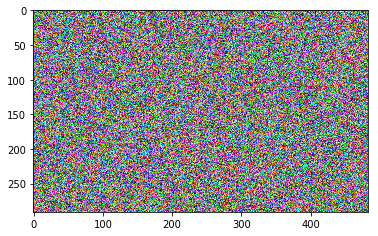

In [22]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 5
x = rand_img(shp)
plt.imshow(deproc(x, shp)[0])

In [23]:
iterations = 10

In [24]:
x = solve_image(evaluator, iterations, x)

Current loss value: [46.93653488]


/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: [18.25113297]
Current loss value: [10.66845417]
Current loss value: [7.77759886]
Current loss value: [6.25022984]
Current loss value: [5.36404657]
Current loss value: [4.73883533]
Current loss value: [4.23235416]
Current loss value: [3.87039399]
Current loss value: [3.61556053]


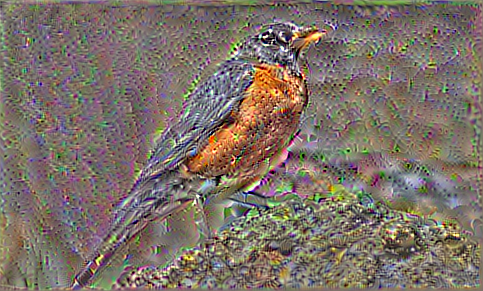

In [25]:
Image.open(path + 'neural-style/results/res_at_iteration_9.png')

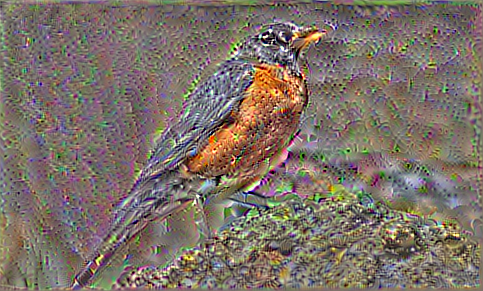

In [26]:
Image.open(path + 'neural-style/results/res_at_iteration_9.png')

In [27]:
from IPython.display import HTML
from matplotlib import animation, rc

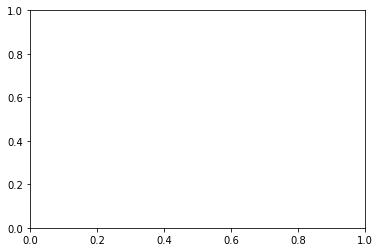

In [28]:
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open(path + 'neural-style/results/res_at_iteration_{i}.png'.format(i=i)))

In [29]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

In [30]:
print(animation.writers.list())

['ffmpeg', 'ffmpeg_file', 'html']


## Recreate style

In [31]:
def plot_arr(arr):
    plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

In [37]:
!ls data

bird.png  simpsons.png	starry_night.png


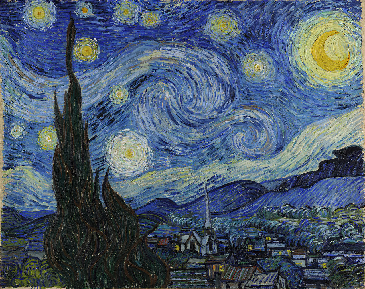

In [117]:
style = Image.open('data/starry_night.png')
# style = style.resize(np.divide(style.size, 3.5).astype('int32'))
style

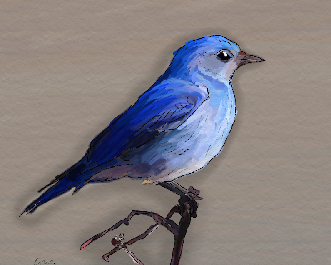

In [38]:
style = Image.open('data/bird.png')
style

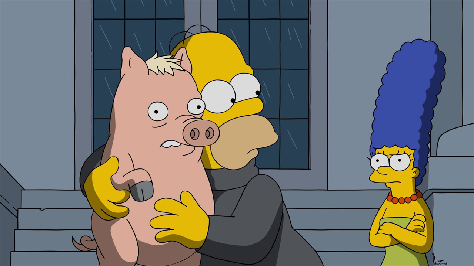

In [118]:
style = Image.open('data/simpsons.png')
style

In [119]:
style_arr = preproc(np.expand_dims(style, 0))
shp = style_arr.shape
shp

(1, 266, 474, 3)

In [120]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/AvgPool:0' shape=(?, 133, 237, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(?, 133, 237, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(?, 133, 237, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/AvgPool:0' shape=(?, 66, 118, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/AvgPool:0' shape=(?, 33, 59, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(?, 33, 59, 512) d

In [121]:
layers = [outputs['block{}_conv1'.format(i)] for i in range(1, 3)]
layers

[<tf.Tensor 'block1_conv1_2/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_2/Relu:0' shape=(?, 133, 237, 128) dtype=float32>]

In [122]:
layers_model = Model(model.input, layers)
targs = [K.variable(x) for x in layers_model.predict(style_arr)]

In [123]:
layers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 266, 474, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 266, 474, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 266, 474, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 133, 237, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 133, 237, 128)     73856     
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


In [124]:
layers_model.output

[<tf.Tensor 'block1_conv1_2/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_2/Relu:0' shape=(?, 133, 237, 128) dtype=float32>]

In [125]:
??K.batch_flatten()

In [126]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [127]:
def style_loss(x, targ):
    return metrics.mse(K.reshape(gram_matrix(x), (1, -1)), K.reshape(gram_matrix(targ), (1, -1)))

In [128]:
loss = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fnc = K.function([model.input], [loss] + grads)
evaluator = Evaluator(style_fnc, shp)

In [129]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])

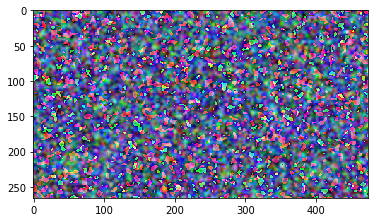

In [130]:
plt.imshow(deproc(x, shp)[0])

In [131]:
x = solve_image(evaluator, iterations, x)

Current loss value: [5465.26074219]


/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 226.17855044163775]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: [653.34051514]


/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: [160.62509155]
Current loss value: [72.23933411]
Current loss value: [38.18897629]
Current loss value: [22.27352142]
Current loss value: [14.74914455]
Current loss value: [10.9682045]
Current loss value: [8.30258369]
Current loss value: [6.61248827]


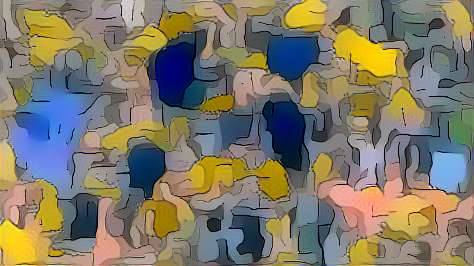

In [132]:
Image.open(path + 'neural-style/results/res_at_iteration_9.png')

## Style transfer

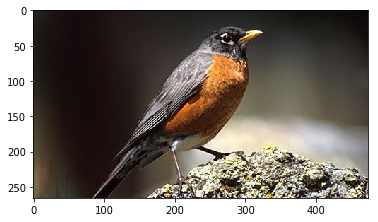

In [133]:
w, h = style.size
src = img_arr[:, :h, :w]
plot_arr(src)

In [134]:
style_layers = [outputs['block{}_conv1'.format(i)] for i in range(1, 6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [135]:
style_model = Model(model.input, style_layers)
content_model = Model(model.input, content_layer)




In [136]:
style_targ = [K.variable(x) for x in style_model.predict(style_arr)]
content_targ = K.variable(content_model.predict([src]))

In [137]:
len(style_targ), style_targ[0].shape

(5, TensorShape([Dimension(1), Dimension(266), Dimension(474), Dimension(64)]))

In [138]:
content_targ.shape

TensorShape([Dimension(1), Dimension(33), Dimension(59), Dimension(512)])

In [139]:
content_layer

<tf.Tensor 'block4_conv2_2/Relu:0' shape=(?, 33, 59, 512) dtype=float32>

In [140]:
loss1 = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targ))
loss2 = metrics.mse(K.reshape(content_layer, (1, -1)), K.reshape(content_targ, (1, -1)))
loss = loss1 + loss2
grads = K.gradients(loss, model.input)
fnc = K.function([model.input], [loss] + grads)
evaluator = Evaluator(fnc, shp)

            

In [141]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])

In [142]:
x = solve_image(evaluator, iterations, x)

Current loss value: [14889.36035156]


/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: [6427.34472656]
Current loss value: [4517.61914062]
Current loss value: [3613.88769531]
Current loss value: [3245.04663086]
Current loss value: [3044.28637695]
Current loss value: [2905.49414062]
Current loss value: [2804.90820312]
Current loss value: [2711.28515625]
Current loss value: [2644.41894531]


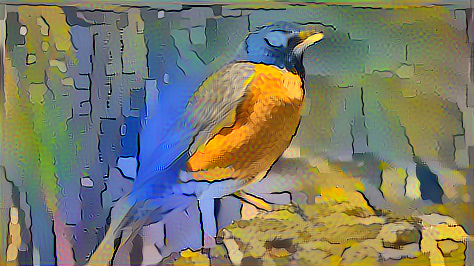

In [143]:
Image.open(path + 'neural-style/results/res_at_iteration_9.png')
